[dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

[Bonne segmentation des clients](https://www.kaggle.com/code/farrasalyafi/eda-customer-segmentatioin)


In [269]:
url = 'https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/download'
zip_file_name = 'brazilian-e-commerce-dataset.zip'
extract_name = 'olist_customers_dataset.csv'
dl_path = 'downloads'
zip_file_path = f'./{dl_path}/{zip_file_name}'
extracts_path = 'extracts'
extract_to_path = f'./{extracts_path}/{extract_name}'

In [270]:
import os

if os.path.isfile(zip_file_path):
    print('File already downloaded')
else:
    # Create the downloads folder
    os.makedirs(dl_path)

    # Download file from url
    import urllib.request
    urllib.request.urlretrieve(url, zip_file_path)
    print('File downloaded')

if os.path.isfile(extract_to_path):
    print('File already extracted')
else:
    # Unzip file
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracts_path)
    print('Files extracted')

File already downloaded
File already extracted


Using this schema to navigate between the different datasets :
![dataset_relation_schema](https://i.imgur.com/HRhd2Y0.png)

As we have to segment clients profiles, we will mostly use the client dataset (olist_order_customer_dataset) related to others.

# Exploration

In order to avoid to explore every dataset, we will do only for data_customer then add a dataset to the exploration part every time we need one.

## Retrieving the data

In [271]:
import pandas as pd

# Reading all the files
raw_path = './extracts/'
data_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
data_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
data_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
data_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
data_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
data_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
data_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
data_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
data_category = pd.read_csv(raw_path + 'product_category_name_translation.csv')

In [272]:
#Menggabungkan semua data-data 
all_data = data_orders.merge(data_order_items, on='order_id', how='left')
all_data = all_data.merge(data_order_payments, on='order_id', how='inner')
all_data = all_data.merge(data_order_reviews, on='order_id', how='inner')
all_data = all_data.merge(data_products, on='product_id', how='inner')
all_data = all_data.merge(data_customer, on='customer_id', how='inner')
all_data = all_data.merge(data_sellers, on='seller_id', how='inner')
all_data = all_data.merge(data_category,on='product_category_name',how='inner')
all_data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
product_category

## 1st : data_customer

### Shape

- `customer_id` : key to the orders dataset. Each order has a unique customer_id.
- `customer_unique_id` : unique identifier of a customer.
- `customer_zip_code_prefix` : first five digits of customer zip code.
- `customer_city` : customer city name.
- `customer_state` : customer state.

In [273]:
print(data_customer.dtypes)
data_customer.head()

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

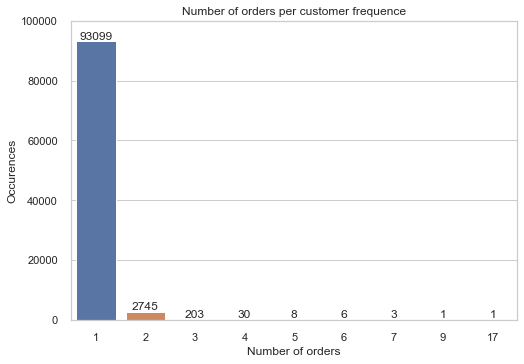

In [274]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

number_of_orders = Counter(data_customer['customer_unique_id'].value_counts().values)
pd_number_of_orders = pd.DataFrame(number_of_orders.items(), columns=['number_of_order_per_customer', 'occurences'])

ax = sns.barplot(x='number_of_order_per_customer', y = 'occurences', data = pd_number_of_orders)
ax.set(xlabel='Number of orders', ylabel='Occurences')
ax.set_title('Number of orders per customer frequence')
ax.set_ylim(0, 100000)
ax.bar_label(ax.containers[0])
plt.show()

In [275]:
data_customer[data_customer.isnull().sum(axis=1) != 0]

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state]
Index: []

No missing values.

### Oultiers

Ids seemed to be in hex with a length of 32, we check that they all fulfill this condition.

In [276]:
import string

if data_customer.loc[data_customer['customer_unique_id'].str.len() != 32,:].shape[0] == 0:
    print('All the customer_unique_id are 32 characters long')
else:
    print('There are some customer_unique_id which are not 32 characters long')

try:
    data_customer['customer_unique_id'].apply(int, base=16)
    print('All the customer_unique_id are in base 16')
except:
    print('There are some customer_unique_id which are not in base 16')
    
if data_customer.loc[data_customer['customer_id'].str.len() != 32,:].shape[0] == 0:
    print('All the customer_id are 32 characters long')
else:
    print('There are some customer_id which are not 32 characters long')

try:
    data_customer['customer_id'].apply(int, base=16)
    print('All the customer_id are in base 16')
except:
    print('There are some customer_id which are not in base 16')

All the customer_unique_id are 32 characters long
All the customer_unique_id are in base 16
All the customer_id are 32 characters long
All the customer_id are in base 16


The other columns on the dataset are not interesting.

## 2nd : data_orders

### Shape

- `order_id` : unique identifier of the order.
- `customer_id` : key to the customer dataset. Each order has a unique customer_id.
- `order_status` : Reference to the order status (delivered, shipped, etc).
- `order_purchase_timestamp` : Shows the purchase timestamp.
- `order_approved_at` : Shows the payment approval timestamp.
- `order_delivered_carrier_date` : Shows the order posting timestamp. When it was handled to the logistic partner.
- `order_delivered_customer_date` : Shows the actual order delivery date to the customer.
- `order_estimated_delivery_date` : Shows the estimated delivery date that was informed to customer at the purchase moment.

In [277]:
print(data_orders.dtypes)
data_orders.head()

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

There are a lot of dates in this dataframe, we will check their distribution by grouping them per month.

Figure(864x1080)


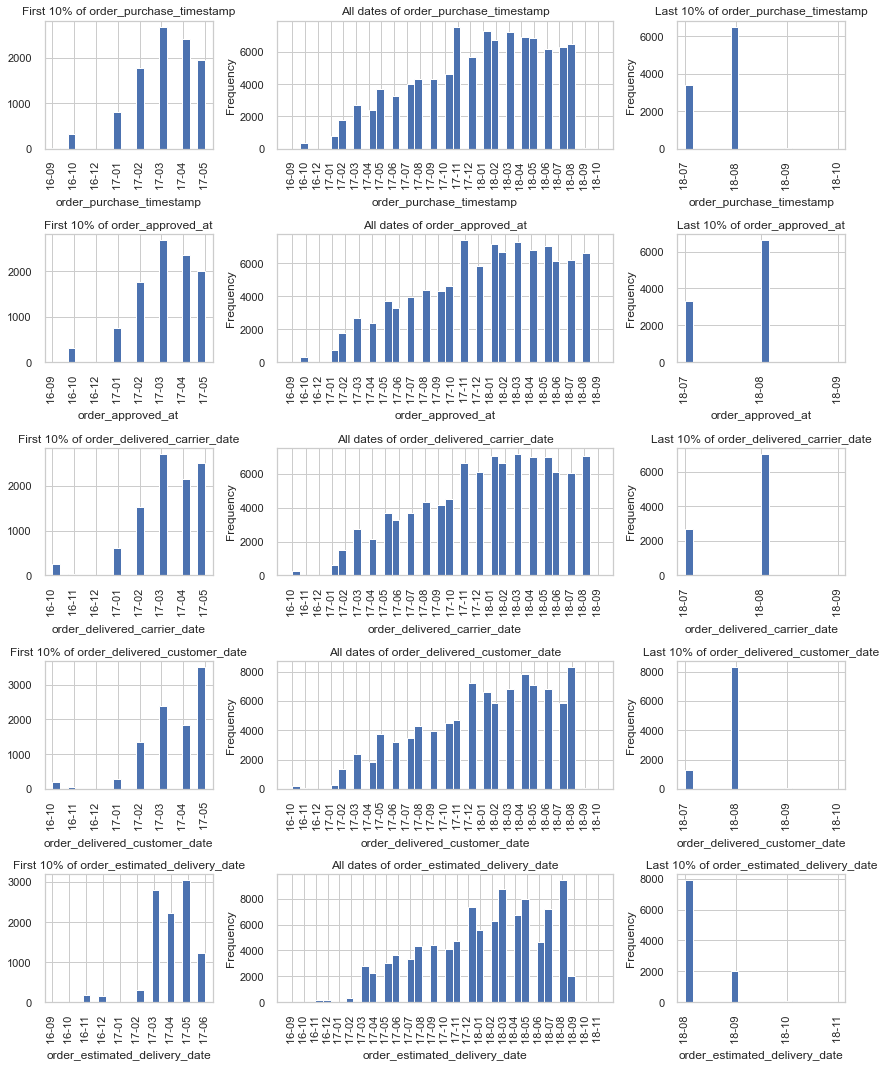

In [278]:
data_orders_date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
data_order_visualization = data_orders[data_orders_date_columns]


fig, axs = plt.subplots(len(data_orders_date_columns),3,gridspec_kw={'width_ratios': [2, 4, 2]}, figsize=(12,15))

for i, column in enumerate(data_orders_date_columns):
    
    sorted_dates = pd.to_datetime(data_order_visualization[column]).dt.strftime(' %y-%m')
    sorted_dates = sorted_dates.dropna()
    sorted_dates = sorted_dates.sort_values(ascending=True)
    hundred_first_dates = sorted_dates.head(round(len(sorted_dates)*0.1))
    hundred_last_dates = sorted_dates.tail(round(len(sorted_dates)*0.1))

    axs[i,0].hist(hundred_first_dates, bins=20)
    axs[i,0].set_title('First 10% of ' + column)
    axs[i,0].set_xlabel(column)
    axs[i,0].tick_params(axis='x', rotation=90)
    
    axs[i,1].hist(sorted_dates, bins=40)
    axs[i,1].set_title('All dates of ' + column)
    axs[i,1].set_xlabel(column)
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].tick_params(axis='x', rotation=90)

    axs[i,2].hist(hundred_last_dates, bins=20)
    axs[i,2].set_title('Last 10% of ' + column)
    axs[i,2].set_xlabel(column)
    axs[i,2].set_ylabel('Frequency')
    axs[i,2].tick_params(axis='x', rotation=90)

plt.tight_layout()
print(fig)

### Oultiers

I think it could be reasonneable to truncate the date from 01 Mar 2017 to 30 Sep 2018.

In [279]:
min_datetime = pd.to_datetime('2017-03-01')
max_datetime = pd.to_datetime('2018-09-30')

# Convert the date to datetime format
data_orders[data_orders_date_columns] = data_orders[data_orders_date_columns].apply(pd.to_datetime)

# If one of the colums is over the max date or under the min date, then we delete the order
conditions = (
    (data_orders['order_purchase_timestamp'] > max_datetime)
    | (pd.to_datetime(data_orders['order_purchase_timestamp']) <  min_datetime)
    | (data_orders['order_approved_at'] > max_datetime)
    | (pd.to_datetime(data_orders['order_approved_at']) <  min_datetime)
    | (data_orders['order_delivered_carrier_date'] > max_datetime)
    | (pd.to_datetime(data_orders['order_delivered_carrier_date']) <  min_datetime)
    | (data_orders['order_delivered_customer_date'] > max_datetime)
    | (pd.to_datetime(data_orders['order_delivered_customer_date']) <  min_datetime)
    | (data_orders['order_estimated_delivery_date'] > max_datetime)
    | (pd.to_datetime(data_orders['order_estimated_delivery_date']) <  min_datetime)
)

orders_to_delete = data_orders[conditions]
print(f"{len(orders_to_delete)} orders will be deleted")
data_orders.drop(orders_to_delete.index, inplace=True)

2975 orders will be deleted


Figure(864x1080)


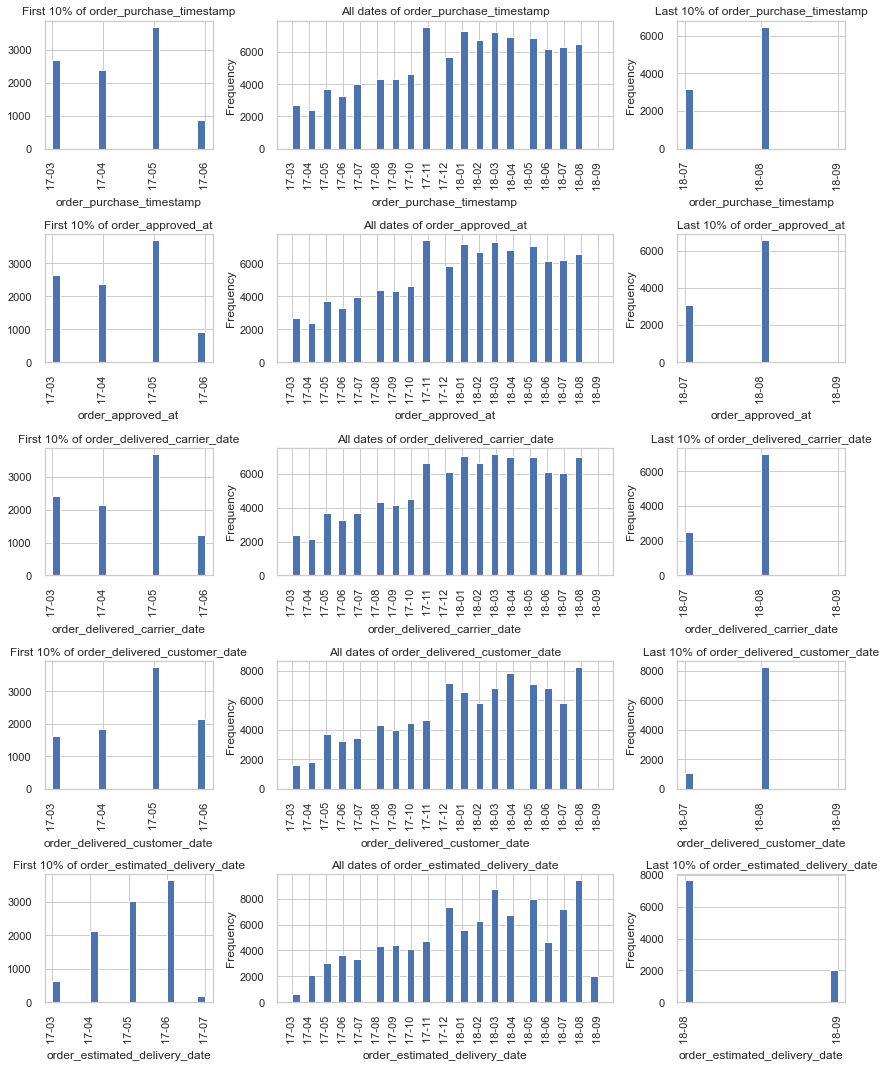

In [280]:
data_order_visualization = data_orders[data_orders_date_columns]


fig, axs = plt.subplots(len(data_orders_date_columns),3,gridspec_kw={'width_ratios': [2, 4, 2]}, figsize=(12,15))

for i, column in enumerate(data_orders_date_columns):
    
    sorted_dates = pd.to_datetime(data_order_visualization[column]).dt.strftime(' %y-%m').dropna()
    sorted_dates = sorted_dates.sort_values(ascending=True)
    hundred_first_dates = sorted_dates.head(round(len(sorted_dates)*0.1))
    hundred_last_dates = sorted_dates.tail(round(len(sorted_dates)*0.1))

    axs[i,0].hist(hundred_first_dates, bins=20)
    axs[i,0].set_title('First 10% of ' + column)
    axs[i,0].set_xlabel(column)
    axs[i,0].tick_params(axis='x', rotation=90)

    axs[i,1].hist(sorted_dates, bins=40)
    axs[i,1].set_title('All dates of ' + column)
    axs[i,1].set_xlabel(column)
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].tick_params(axis='x', rotation=90)

    axs[i,2].hist(hundred_last_dates, bins=20)
    axs[i,2].set_title('Last 10% of ' + column)
    axs[i,2].set_xlabel(column)
    axs[i,2].set_ylabel('Frequency')
    axs[i,2].tick_params(axis='x', rotation=90)

plt.tight_layout()
print(fig)

In [281]:
if data_orders.loc[data_orders['order_id'].str.len() != 32,:].shape[0] == 0:
    print('All the order_id are 32 characters long')
else:
    print('There are some order_id which are not 32 characters long')

try:
    data_orders['order_id'].apply(int, base=16)
    print('All the order_id are in base 16')
except:
    print('There are some order_id which are not in base 16')
    
if data_orders.loc[data_orders['customer_id'].str.len() != 32,:].shape[0] == 0:
    print('All the customer_id are 32 characters long')
else:
    print('There are some customer_id which are not 32 characters long')

try:
    data_orders['customer_id'].apply(int, base=16)
    print('All the customer_id are in base 16')
except:
    print('There are some customer_id which are not in base 16')

All the order_id are 32 characters long
All the order_id are in base 16
All the customer_id are 32 characters long
All the customer_id are in base 16


## 3rd : data_order_payments

### Shape

- `order_id` : unique identifier of the order.
- `payment_sequential` : a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments.
- `payment_type` : method of payment chosen by the customer.
- `payment_installments` : number of installments chosen by the customer.
- `payment_value` : transaction value.

In [282]:
print(data_order_payments.dtypes)
data_order_payments.head()

order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [283]:
data_order_payments.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [284]:
data_order_payments.var()

C:\Users\augustin\AppData\Local\Temp\ipykernel_5460\1454748336.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_order_payments.var()


payment_sequential          0.499261
payment_installments        7.220241
payment_value           47303.667816
dtype: float64

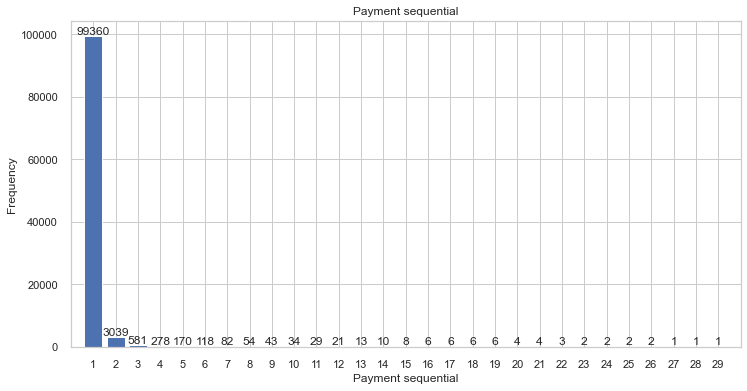

In [285]:
sequential_payments = data_order_payments['payment_sequential'].value_counts()
fig, ax = plt.subplots(figsize=(12,6))
barplot = ax.bar(x = sequential_payments.index, height=sequential_payments.values)
ax.bar_label(barplot)
ax.set_title('Payment sequential')
ax.set_xlabel('Payment sequential')
ax.set_ylabel('Frequency')
ax.set_xlim(0,30)
ax.set_xticks(sequential_payments.index)
plt.show()

C:\Users\augustin\AppData\Local\Temp\ipykernel_5460\262555104.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  values_counts = values_counts.append({'index':'others', column:others_sum}, ignore_index=True)
C:\Users\augustin\AppData\Local\Temp\ipykernel_5460\262555104.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  values_counts = values_counts.append({'index':'others', column:others_sum}, ignore_index=True)
C:\Users\augustin\AppData\Local\Temp\ipykernel_5460\262555104.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  values_counts = values_counts.append({'index':'others', column:others_sum}, ignore_index=True)


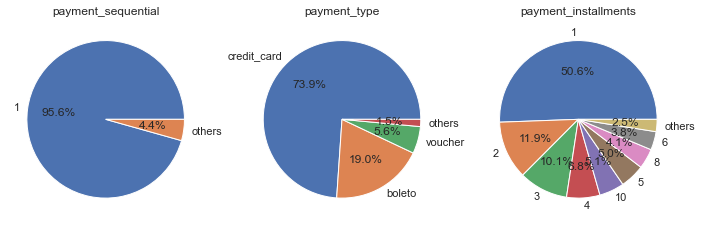

In [286]:
import numpy as np

to_pie_plot_columns = ['payment_sequential', 'payment_type', 'payment_installments']
others_percent_threshold = 3

fig, ax = plt.subplots(1, len(to_pie_plot_columns), figsize=(12,6))
for i, column in enumerate(to_pie_plot_columns):
    values_counts = data_order_payments[column].value_counts()
    total_values = values_counts.sum()
    others_index = values_counts[values_counts/total_values*100 < others_percent_threshold].index
    values_others = values_counts[others_index]
    values_counts = values_counts.drop(others_index)
    others_sum = values_others.sum()

    values_counts = values_counts.reset_index()
    values_counts['index'] = values_counts['index'].astype(str)
    values_counts = values_counts.append({'index':'others', column:others_sum}, ignore_index=True)


    ax[i].pie(x=values_counts[column], labels =values_counts['index'] , autopct='%1.1f%%')
    ax[i].set_title(column)
plt.show()

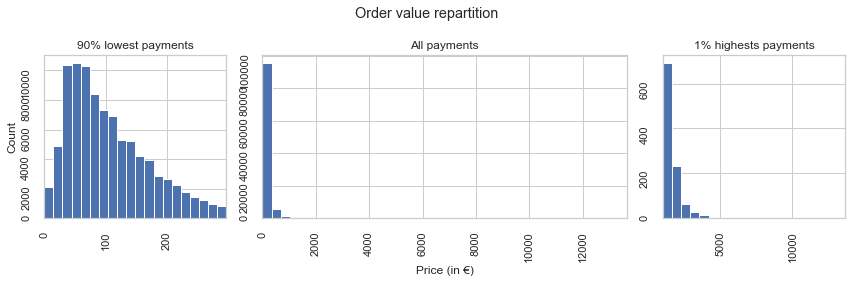

In [287]:
fig, axs = plt.subplots(1,3,gridspec_kw={'width_ratios': [2, 4, 2]}, figsize=(12,4))

payments_sorted = data_order_payments['payment_value'].sort_values(ascending=True)
nb_payments = len(payments_sorted)
ten_percent_first = payments_sorted.head(round(0.9 * nb_payments))
ten_percent_last = payments_sorted.tail(round(0.01 * nb_payments))

axs[0].hist(ten_percent_first, bins=20)
axs[0].set_title('90% lowest payments')
axs[0].tick_params(rotation=90)
axs[0].set_xlim(0, max(ten_percent_first))
axs[0].set_ylabel('Count')

axs[1].hist(payments_sorted, bins=40)
axs[1].set_title('All payments')
axs[1].tick_params(rotation=90)
axs[1].set_xlim(min(payments_sorted), max(payments_sorted))
axs[1].set_xlabel('Price (in €)')

axs[2].hist(ten_percent_last, bins=20)
axs[2].set_title('1% highests payments')
axs[2].tick_params(rotation=90)
axs[2].set_xlim(min(ten_percent_last), max(ten_percent_last))

fig.suptitle('Order value repartition')


plt.tight_layout()

## 4th : data_order_reviews

### Shape

In [288]:
data_order_reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [289]:
data_order_reviews.shape

(99224, 7)

In [290]:
data_order_reviews.describe()

review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

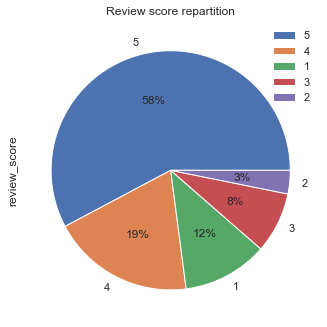

1    11424
2     3151
3     8179
4    19142
5    57328
Name: review_score, dtype: int64

In [291]:
reviews_counts = data_order_reviews.loc[:, 'review_score'].value_counts()
reviews_counts.plot.pie(autopct='%1.0f%%', title = 'Review score repartition').legend()
plt.show()
reviews_counts.sort_index()

88.34% of reviews have no title (87656/99224)
58.7% of reviews have no message (58247/99224)


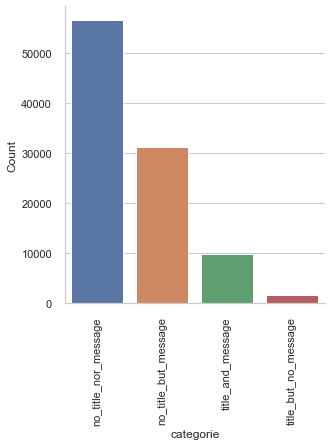

In [292]:
import seaborn as sns

no_title_reviews = data_order_reviews.loc[:, 'review_comment_title'].isna()
no_message_reviews = data_order_reviews.loc[:, 'review_comment_message'].isna()
total_reviews = data_order_reviews.shape[0]
print(f"{round(no_title_reviews.sum()*100/total_reviews,2)}% of reviews have no title ({no_title_reviews.sum()}/{total_reviews})")
print(f"{round(no_message_reviews.sum()*100/total_reviews,2)}% of reviews have no message ({no_message_reviews.sum()}/{total_reviews})")

no_title_nor_message = no_title_reviews & no_message_reviews
no_title_but_message = no_title_reviews & ~no_message_reviews
title_and_message = ~no_title_reviews & ~no_message_reviews
title_but_no_message = ~no_title_reviews & no_message_reviews

reviews_population = pd.DataFrame([
                                    ['no_title_nor_message', no_title_nor_message.sum()],
                                    ['no_title_but_message', no_title_but_message.sum()],
                                    ['title_and_message', title_and_message.sum()],
                                    ['title_but_no_message', title_but_no_message.sum()],
                                ],
                                columns = ['categorie', 'Count'])

review_barplot = sns.catplot(data = reviews_population, x = 'categorie', y = 'Count', kind = 'bar')
plt.xticks(rotation=90)
plt.show()

Reviews really started to grow up around january 2017.


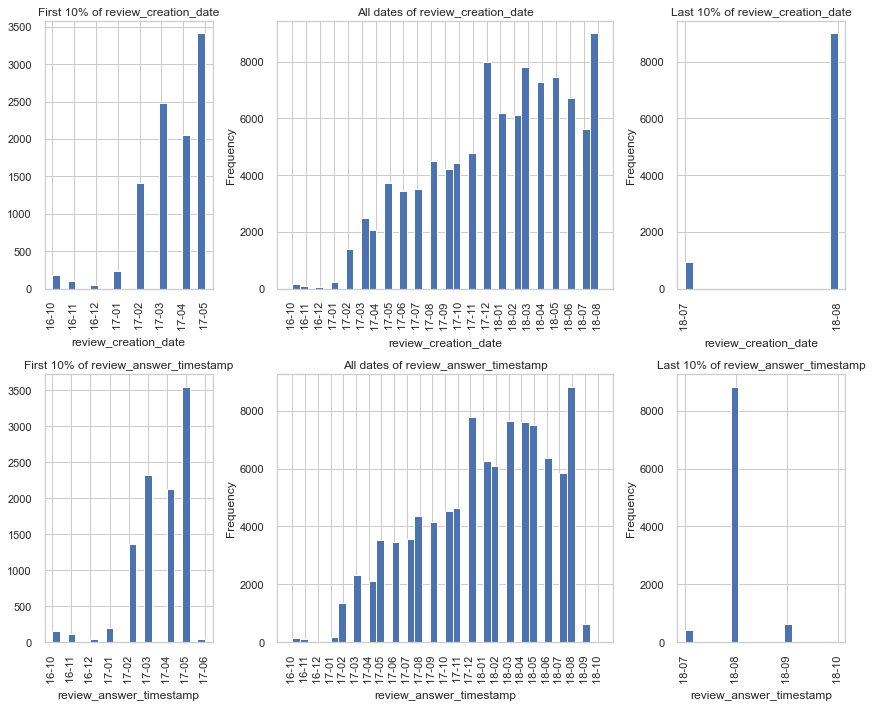

In [293]:
data_reviews_date_columns = ['review_creation_date', 'review_answer_timestamp']
data_reviews_visualization = data_order_reviews[data_reviews_date_columns]


fig, axs = plt.subplots(len(data_reviews_date_columns),3,gridspec_kw={'width_ratios': [2, 4, 2]}, figsize=(12,10))

for i, column in enumerate(data_reviews_date_columns):
    
    sorted_dates = pd.to_datetime(data_reviews_visualization[column]).dt.strftime(' %y-%m').dropna()
    sorted_dates = sorted_dates.sort_values(ascending=True)
    hundred_first_dates = sorted_dates.head(round(len(sorted_dates)*0.1))
    hundred_last_dates = sorted_dates.tail(round(len(sorted_dates)*0.1))

    axs[i,0].hist(hundred_first_dates, bins=20)
    axs[i,0].set_title('First 10% of ' + column)
    axs[i,0].set_xlabel(column)
    axs[i,0].tick_params(axis='x', rotation=90)

    axs[i,1].hist(sorted_dates, bins=40)
    axs[i,1].set_title('All dates of ' + column)
    axs[i,1].set_xlabel(column)
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].tick_params(axis='x', rotation=90)

    axs[i,2].hist(hundred_last_dates, bins=20)
    axs[i,2].set_title('Last 10% of ' + column)
    axs[i,2].set_xlabel(column)
    axs[i,2].set_ylabel('Frequency')
    axs[i,2].tick_params(axis='x', rotation=90)

plt.tight_layout()

print('Reviews really started to grow up around january 2017.')

# Feature extraction

Feuille de route :

1. Faire un premier jeu de variables avec RFM --> Date de la dernière commande | Nombre de commandes | Total dépensé
2. Faire le clustering sur ces variables sur une période fixe (toute l'année) puis du flotant
3. Rajouter les features et refaire un clustering (avec des [réductions de dimensionnalité](https://scikit-learn.org/stable/modules/unsupervised_reduction.html#data-reduction) ?)
4. Rajouter plusieurs algorithmes
5. Faire de l'interpretation en pensant au point de vue marketing

Features interessantes :
- Temps médian entre les commandes
- Somme médianne des commandes
- Mois avec le plus de commandes (avec une pondération ?)
- Catégorie préférée (attention, variable catégorielle)
- Score moyen des reviews
- "A laissé une review"

Adding new features to a custom dataframe representing a customer.
Adding :
- **Recency** (How recently did the customer purchase?) : When was the last order
- **Frequency** (How often do they purchase?) : Average time between orders (time signed up / number of orders)
- **Monetary Value** (How much do they spend?) : What is the median of the order value
- **number of orders** : How many orders the customer has made.
- **customer's seniority** : How long the customer has been a customer.
- **total spent** : How much the customer has spent
- **prefered category** : What is the prefered category of the customer
- **most spent month** : Month with the most orders
- **average review score** : Average review score of the customer
  
Every date is transformed into a number of days from now. And we consider (even if it isn't mentionned) that the times are in UTC.
Also, in order to calculate the customer's seniority, we consider the current date as the 01/01/2019 because the dataset gathers data from 2016 to 2018.

Imputing is done in this step because when preprocessing, it'll be harder to impute for each case.

Outliers eviction is also done at this step with a another dataset.

In [294]:
from sklearn.impute import SimpleImputer

custom_customers_df = data_customer[['customer_unique_id', 'customer_id']].drop_duplicates()
reduced_custom_customers_df = data_customer[['customer_unique_id', 'customer_id']].drop_duplicates()

## Recency

**Recency** (How recently did the customer purchase?) : When was the last order

In [295]:
from datetime import datetime

# Keeping the relation from order customer id and customer unique id
custom_orders_df = data_customer[['customer_unique_id', 'customer_id']]
# Getting the orders details
custom_orders_df = custom_orders_df.merge(data_orders, on='customer_id', how='inner')
# Grouping every customer by their customer_unique_id and selecting the most recent order date (and renaming it)
custom_orders_most_recent_df = custom_orders_df.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()
custom_orders_most_recent_df['Recency'] = (max_datetime - pd.to_datetime(custom_orders_most_recent_df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')).dt.days
custom_orders_most_recent_df = custom_orders_most_recent_df.drop('order_purchase_timestamp', axis=1)

SimpleImputer().fit_transform(np.array(custom_orders_most_recent_df['Recency']).reshape(-1, 1))

# Adding recency column to the custom_customers_df
custom_customers_df = custom_customers_df.merge(custom_orders_most_recent_df, on='customer_unique_id', how='inner')

custom_customers_df



customer_unique_id                       customer_id  \
0      861eff4711a542e4b93843c6dd7febb0  06b8999e2fba1a1fbc88172c00ba8bc7   
1      290c77bc529b7ac935b93aa66c333dc3  18955e83d337fd6b2def6b18a428ac77   
2      060e732b5b29e8181a18229c7b0b2b5e  4e7b3e00288586ebd08712fdd0374a03   
3      259dac757896d24d7702b9acbbff3f3c  b2b6027bc5c5109e529d4dc6358b12c3   
4      345ecd01c38d18a9036ed96c73b8d066  4f2d8ab171c80ec8364f7c12e35b23ad   
...                                 ...                               ...   
96566  1a29b476fee25c95fbafc67c5ac95cf8  17ddf5dd5d51696bb3d7c6291687be6f   
96567  d52a67c98be1cf6a5c84435bd38d095d  e7b71a9017aa05c9a7fd292d714858e8   
96568  e9f50caf99f032f0bf3c55141f019d99  5e28dfe12db7fb50a4b2f691faecea5e   
96569  73c2643a0a458b49f58cea58833b192e  56b18e2166679b8a959d72dd06da27f9   
96570  84732c5050c01db9b23e19ba39899398  274fa6071e5e17fe303b9748641082c8   

       Recency  
0          501  
1          260  
2          133  
3          200  
4           62  
...        ...  
96566      175  
96567      178  
96568      174  
96569      330  
96570      284  

[96571 rows x 3 columns]

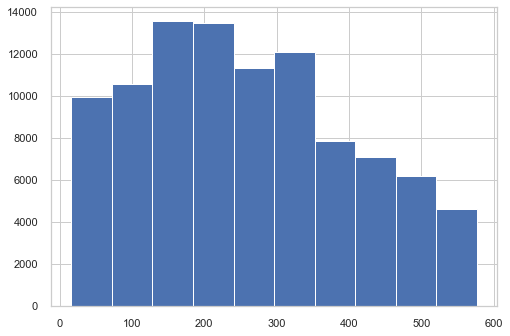

It seems there is no need for outlier selection


In [296]:
plt.hist(custom_customers_df['Recency'])
plt.show()

print('It seems there is no need for outlier selection')
reduced_custom_customers_df = reduced_custom_customers_df.merge(custom_orders_most_recent_df, on='customer_unique_id', how='inner')

## Frequency

In [297]:
orders_per_customer = custom_orders_df['customer_unique_id'].value_counts()
orders_per_customer = pd.DataFrame(orders_per_customer.items(), columns=['customer_unique_id', 'number_of_orders'])
orders_per_customer = orders_per_customer.rename(columns={'number_of_orders': 'Frequency'})
SimpleImputer().fit_transform(np.array(orders_per_customer['Frequency']).reshape(-1, 1))

custom_customers_df = custom_customers_df.merge(orders_per_customer, on='customer_unique_id', how='inner')
custom_customers_df.sort_values('Frequency', ascending=False)

customer_unique_id                       customer_id  \
14684  8d50f5eadf50201ccdcedfb9e2ac8455  a682769c4bc10fc6ef2101337a6c83c9   
14690  8d50f5eadf50201ccdcedfb9e2ac8455  0bf8bf19944a7f8b40ba86fef778ca7c   
14682  8d50f5eadf50201ccdcedfb9e2ac8455  65f9db9dd07a4e79b625effa4c868fcb   
14685  8d50f5eadf50201ccdcedfb9e2ac8455  6289b75219d757a56c0cce8d9e427900   
14686  8d50f5eadf50201ccdcedfb9e2ac8455  3414a9c813e3ca02504b8be8b2deb27f   
...                                 ...                               ...   
34157  94066d7cd0c170e588e28030789bff1c  74b45de02962e748eb6da766e9c84ddf   
34156  aadc40788e65bfd96c733803daeebbcd  a890c03e9d0445e3f23f331a4fa21a1c   
34155  6dd4bb9e1c36c337cf410d9cc332c8ab  37955c5c4ea9ed8cdb555c4743e00d0c   
34154  db677db84c5f3ca01d0842fb35ba3be6  3fa0f0d17dcb1c898d6e6bd095c2d254   
96570  84732c5050c01db9b23e19ba39899398  274fa6071e5e17fe303b9748641082c8   

       Recency  Frequency  
14684       40         17  
14690       40         17  
14682       40         17  
14685       40         17  
14686       40         17  
...        ...        ...  
34157      293          1  
34156      216          1  
34155      188          1  
34154      112          1  
96570      284          1  

[96571 rows x 4 columns]

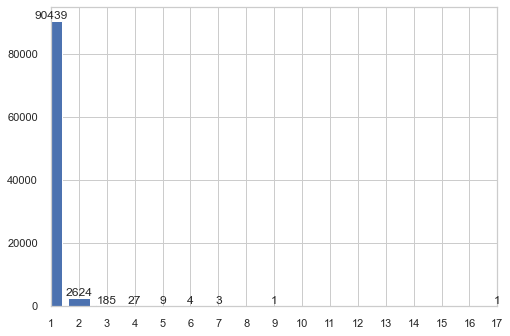

We need to make a selection. We delete every user with a frequency over 4 (not included)


In [298]:
frequency_counts = orders_per_customer['Frequency'].value_counts()
fig, ax = plt.subplots()
bars = ax.bar(frequency_counts.index, frequency_counts.values)
ax.bar_label(bars)
ax.set_xticks(np.arange(min(frequency_counts.index), max(frequency_counts.index)+1, step=1), rotation=90)
ax.set_xlim(min(frequency_counts.index), max(frequency_counts.index))

plt.show()

print('We need to make a selection. We delete every user with a frequency over 4 (not included)')


reduced_orders_per_customer = orders_per_customer[orders_per_customer['Frequency'] <= 4].sort_values('Frequency', ascending = False)
reduced_custom_customers_df = reduced_custom_customers_df.merge(reduced_orders_per_customer, on='customer_unique_id', how='inner')

## Monetary value

In [299]:
merged_orders = data_order_payments.merge(data_orders, on='order_id', how='inner').merge(data_customer, on='customer_id', how='inner')
merged_orders = merged_orders.groupby('customer_unique_id').agg({'payment_value': 'sum'}).reset_index().sort_values(by='payment_value', ascending=False)
merged_orders = merged_orders.rename(columns={'payment_value': 'Monetary_value'})
SimpleImputer().fit_transform(np.array(merged_orders['Monetary_value']).reshape(-1, 1))


custom_customers_df = custom_customers_df.merge(merged_orders, on='customer_unique_id', how='left')

merged_orders.sort_values('Monetary_value', ascending=False)

customer_unique_id  Monetary_value
3712   0a0a92112bd4c708ca5fde585afaa872        13664.08
25694  46450c74a0d8c5ca9395da1daac6c120         9553.02
79585  da122df9eeddfedc1dc1f5349a1a690c         7571.63
43170  763c8b1c9c68a0229c42c9fc6f662b93         7274.88
25454  459bef486812aa25204be022145caa62         6922.21
...                                 ...             ...
65446  b33336f46234b24a613ad9064d13106d           10.89
68997  bd06ce0e06ad77a7f681f1a4960a3cc6           10.07
18096  317cfc692e3f86c45c95697c61c853a6            9.59
29101  4fa4365000c7090fcb8cad5713c6d3db            0.00
54895  968fac81e2c44fb6c1e3ac2a45e6a102            0.00

[93293 rows x 2 columns]

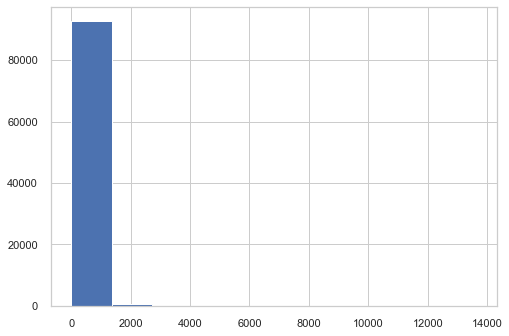

We need to cut under 900




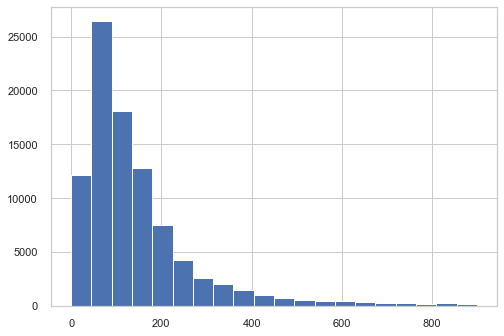

Better


In [300]:
plt.hist(merged_orders['Monetary_value'])
plt.show()
print('We need to cut under 900\n\n')

under_900_orders = merged_orders[merged_orders['Monetary_value']<=900]
plt.hist(under_900_orders['Monetary_value'], bins=20)
plt.show()
print('Better')

In [301]:
reduced_custom_customers_df = reduced_custom_customers_df.merge(under_900_orders, on='customer_unique_id', how='inner')

# Clustering

Using [this](https://scikit-learn.org/stable/modules/clustering.html) guide to find the best algorithm :
- [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means) : why not --> **40s** to fit
- ~~[Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) : complexity of o(n²t) with n samples~~ so **too much complexity**
- ~~[Mean Shift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift) : why not~~ **takes too long**
- ~~[SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering) : not suited~~ **Can't take that many sample**
- ~~[Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) : why not~~ **Can't take that many sample**
- [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan) : may be interesting --> **80s** to fit
- ~~[OPTICS](https://scikit-learn.org/stable/modules/clustering.html#optics) : if DBSCAN works, why not~~ **takes too long**
- [Gaussian Mixture](https://scikit-learn.org/stable/modules/mixture.html#gaussian-mixture) : sounds cool --> **0.29s to fit**


## Preprocessing

In [302]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def preprocessing():
    return Pipeline([
        ('scaler', StandardScaler())
    ])

In [340]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

def visual3D(
            dataX,
            dataY,
            dataZ,
            labels,
            labelX = None,
            labelY = None,
            labelZ = None,
            mplt=True,
            title=None,
            colMap='Set1',
            revertedX = False,
            revertedY = False,
            revertedZ = False
        ):
    
    fig = plt.figure(1, figsize=(12,6))
    
    if (mplt == True):
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(dataX, dataY, dataZ, c=labels, cmap=colMap)
    else:
        ax = Axes3D(fig, rect=[0, 0, 1, 1], auto_add_to_figure=False)
        ax.scatter(dataX, dataY, dataZ, c=labels, cmap=colMap)
        fig.add_axes(ax)
    
    
    ax.set_title(title)
    
    ax.set_xlabel(labelX)
    xlim = (ax.get_xlim()[::-1]) if revertedX else (min(dataX),max(dataX))
    ax.set_xlim(xlim)
    
    ax.set_ylabel(labelY)
    ylim = (ax.get_ylim()[::-1]) if revertedY else (min(dataY),max(dataY))
    ax.set_ylim(ylim)
    
    ax.set_zlabel(labelZ)
    zlim = (ax.get_zlim()[::-1]) if revertedZ else (min(dataZ),max(dataZ))
    ax.set_zlim(zlim)
    
    ax.legend()
    plt.show()

In [304]:
import re
from yellowbrick.cluster import silhouette_visualizer

def describe_clusters(
    dataX,
    dataY,
    dataZ,
    columns,
    estimator,
    isfitted = True
):
    # Next regex returns any digits at the end of a word starting with "label".
    # label1 --> '1'
    # label34 --> '34'
    # blabel2 --> nothing
    # label5b --> nothing
    clusters_list = re.finditer(r"(?<=\blabel)\d+\b", str(columns))
    for cluster_match in clusters_list:
        cluster_number = int(cluster_match.group())
        print(f'Doing with {str(cluster_number)} clusters')

## K-means

With [these tools](https://www.scikit-yb.org/en/latest/api/cluster/index.html).

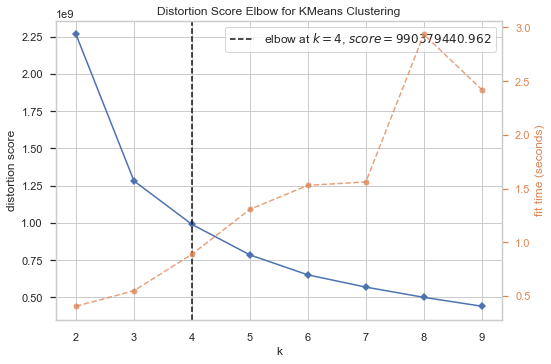

optimal number of cluster is 4


In [305]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer

red_data = reduced_custom_customers_df.loc[:,['Recency', 'Frequency', 'Monetary_value']]
# Use the quick method and immediately show the figure
model = KElbowVisualizer(KMeans(), k=(2,10))
model.fit(red_data)
model.show()
optimal_cluster_number = model.elbow_value_
print(f"optimal number of cluster is {str(optimal_cluster_number)}")

C:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 5\Clustering-Model-Designing\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


215.89s to fit


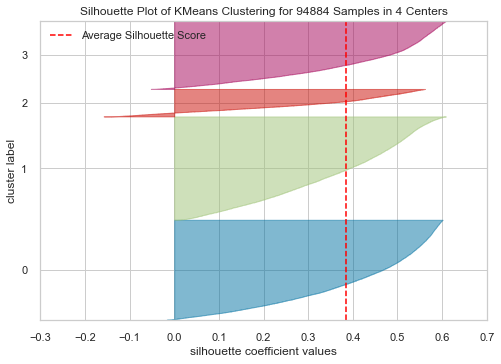

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94884 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [306]:
from yellowbrick.cluster import SilhouetteVisualizer
import time

# Instantiate the clustering model and visualizer
model = KMeans(optimal_cluster_number, random_state=42)
model.fit(red_data)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted = True)
start_data = time.time()
visualizer.fit(red_data)
stop_data = time.time()
time_to_fit = stop_data - start_data
print(f'{round(time_to_fit,2)}s to fit')
visualizer.show()        # Finalize and render the figure

C:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 5\Clustering-Model-Designing\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


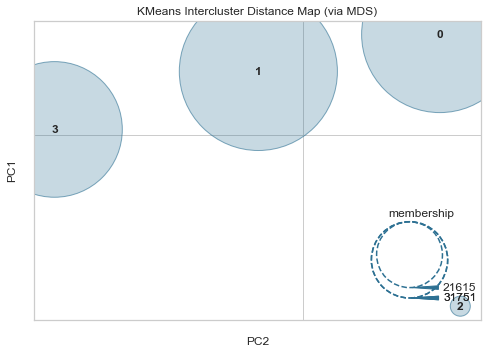

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [307]:
from yellowbrick.cluster.icdm import InterclusterDistance

visualizer = InterclusterDistance(model, is_fitted = True, legend_loc = 'lower right')

visualizer.fit(red_data)

visualizer.show()        # Finalize and render the figure

started at 15:08:12


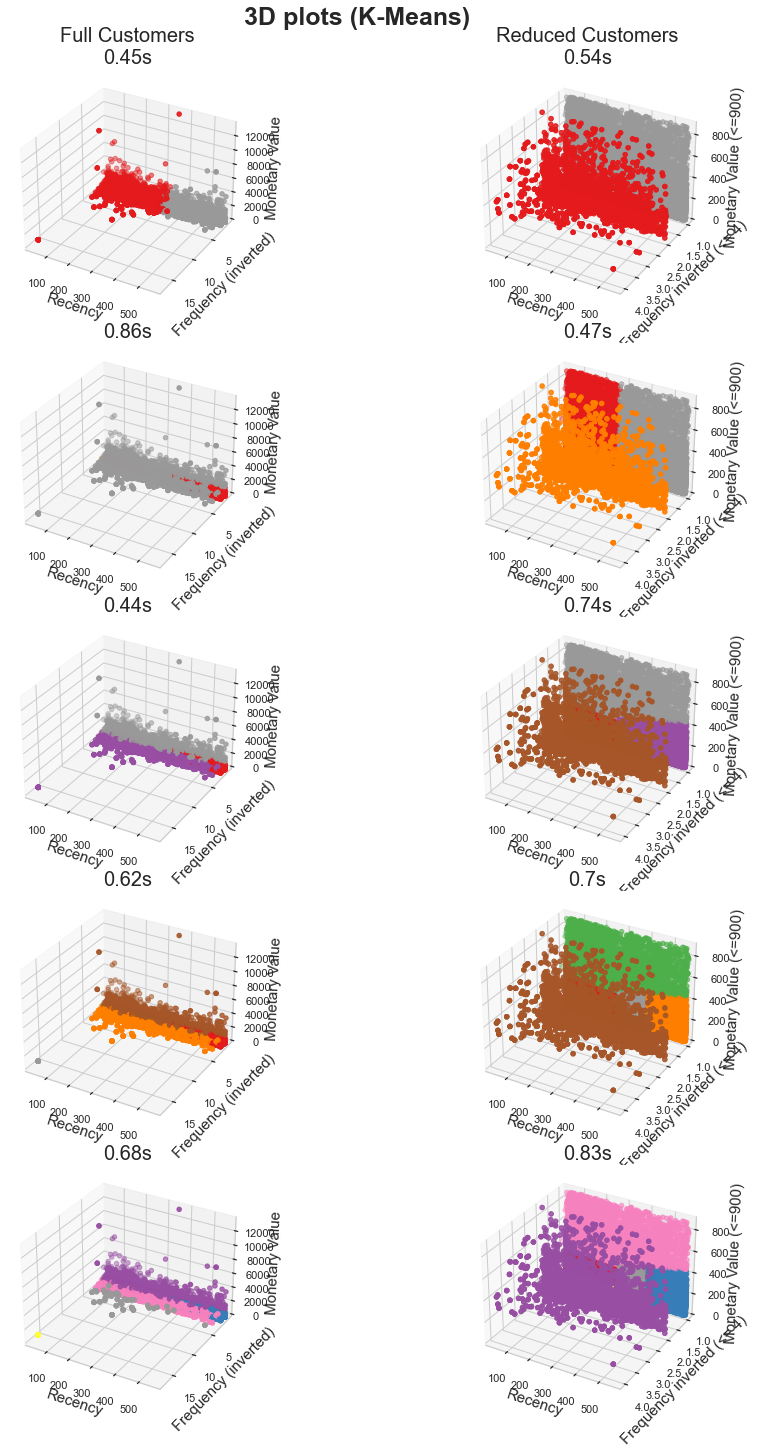

In [308]:
import time
from datetime import datetime
from sklearn.cluster import KMeans

# 2 to 6
nb_clusters = range(2,7)
title_fontsize = 25
fig_axis_fontsize = 20
axis_fontsize = 15


data = custom_customers_df.loc[:,['Recency', 'Frequency', 'Monetary_value']]
red_data = reduced_custom_customers_df.loc[:,['Recency', 'Frequency', 'Monetary_value']]



fig = plt.figure(figsize=(16,20))
plt.suptitle('3D plots (K-Means)', fontsize=title_fontsize, fontweight='bold')

print(f"started at {datetime.now().strftime('%H:%M:%S')}")
for index, nb_clust in enumerate(nb_clusters):
    KMPipe = Pipeline([
        ('preprocessing', preprocessing()),
        ('KMeans', KMeans(n_clusters=nb_clust))
    ])
    
    # Ax with the complete data
    
    start_data = time.time()
    data['label' + str(nb_clust)] = KMPipe.fit(data)['KMeans'].labels_
    stop_data = time.time()
    time_data = stop_data - start_data
    
    ax_full = fig.add_subplot(len(nb_clusters),2,index*2+1, projection = '3d')
    ax_full.scatter3D(
                data.loc[:,'Recency'],
                data.loc[:,'Frequency'],
                data.loc[:,'Monetary_value'],
                c=data.loc[:,'label' + str(nb_clust)],
                cmap='Set1',
            )
    ax_full.set_xlabel('Recency', fontsize=axis_fontsize)
    ax_full.set_xlim(min(data.loc[:,'Recency']),max(data.loc[:,'Recency']))
    
    ax_full.set_ylabel('Frequency (inverted)', fontsize=axis_fontsize)
    ax_full.set_ylim(ax_full.get_ylim()[::-1])
    
    ax_full.set_zlabel('Monetary Value', fontsize=axis_fontsize)
    ax_full.set_zlim(min(data.loc[:,'Monetary_value']),max(data.loc[:,'Monetary_value']))
    
    ax_full.set_title(f"{round(time_data,2)}s", fontsize=fig_axis_fontsize)
     
    
    # Ax with the reduced data
    
    start_red = time.time()
    red_data['label' + str(nb_clust)] = KMPipe.fit(red_data)['KMeans'].labels_
    stop_red = time.time()
    time_red = stop_red - start_red
    
    
    ax_reduced = fig.add_subplot(len(nb_clusters),2,index*2+2, projection = '3d')
    ax_reduced.scatter3D(
                red_data.loc[:,'Recency'],
                red_data.loc[:,'Frequency'],
                red_data.loc[:,'Monetary_value'],
                c=red_data.loc[:,'label' + str(nb_clust)],
                cmap='Set1',
            )
    ax_reduced.set_xlabel('Recency', fontsize=axis_fontsize)
    ax_reduced.set_xlim(min(red_data.loc[:,'Recency']),max(red_data.loc[:,'Recency']))
    
    ax_reduced.set_ylabel('Frequency inverted (<= 4)', fontsize=axis_fontsize)
    ax_reduced.set_ylim(ax_reduced.get_ylim()[::-1])
    
    ax_reduced.set_zlabel('Monetary Value (<=900)', fontsize=axis_fontsize)
    ax_reduced.set_zlim(min(red_data.loc[:,'Monetary_value']),max(red_data.loc[:,'Monetary_value']))
    
    ax_reduced.set_title(f"{round(time_red,2)}s", fontsize=fig_axis_fontsize)
    
    # Adding column title
    if index == 0:
        ax_full.set_title(f'Full Customers\n{round(time_data,2)}s', fontsize=fig_axis_fontsize)
        ax_reduced.set_title(f'Reduced Customers\n{round(time_red,2)}s', fontsize=fig_axis_fontsize)

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


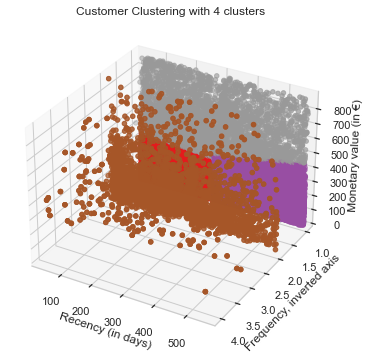

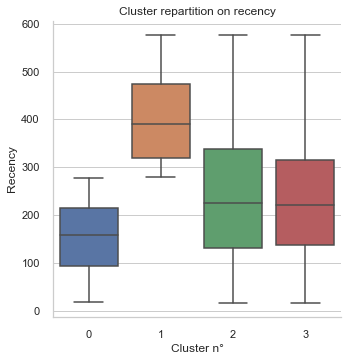

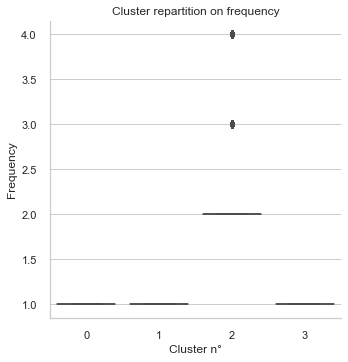

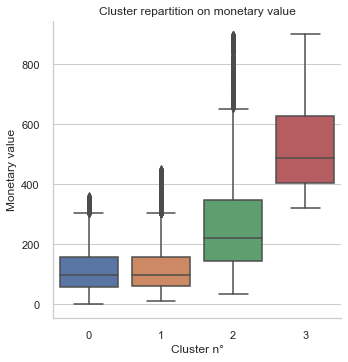

In [309]:
import seaborn as sns

visual3D(
            red_data.loc[:,'Recency'],
            red_data.loc[:,'Frequency'],
            red_data.loc[:,'Monetary_value'],
            red_data.loc[:,'label4'],
            labelX = 'Recency (in days)',
            labelY = 'Frequency, inverted axis',
            labelZ = 'Monetary value (in €)',
            mplt=True,
            title='Customer Clustering with 4 clusters',
            colMap='Set1',
            revertedX = False,
            revertedY = True,
            revertedZ = False
        )

label_col = 'label4'

max_datetime = pd.to_datetime('2018-09-30')

data_to_box = red_data.loc[:,['Recency', 'Frequency', 'Monetary_value', 'label4']]


# Ploting Recency

rec_plot = sns.catplot(data = data_to_box, x = label_col, y = 'Recency', kind = 'box')
rec_plot.set_axis_labels("Cluster n°", "Recency").set(title = 'Cluster repartition on recency')
# # We can do that to convert to 'yy-mm'
# data_to_box['Purchase Date'] = data_to_box['Recency'].apply(lambda x :max_datetime - pd.to_timedelta(x, unit='d')).dt.strftime('%y-%m')


# Ploting Frequency
freq_plot = sns.catplot(data = data_to_box, x = label_col, y = 'Frequency', kind = 'box')
freq_plot.set_axis_labels("Cluster n°", "Frequency").set(title = 'Cluster repartition on frequency')

# Ploting Monetary value
mon_plot = sns.catplot(data = data_to_box, x = label_col, y = 'Monetary_value', kind = 'box')
mon_plot.set_axis_labels("Cluster n°", "Monetary value").set(title = 'Cluster repartition on monetary value')

In [310]:
print('Nombre de clients par cluster')
display_df = data_to_box['label4'].value_counts().reset_index().rename(columns={'index':'n_clust','label4':'nb_cust'})
# display_df['nb_cust'] / display_df['nb_cust'].sum()
display_df['customers_percent'] = round(display_df['nb_cust'] * 100 / display_df['nb_cust'].sum(),2)
display_df.sort_values('n_clust')

Nombre de clients par cluster


n_clust  nb_cust  customers_percent
0        0    47557              50.12
1        1    36187              38.14
2        2     5687               5.99
3        3     5453               5.75

## DBSCAN

In [311]:
# From https://stackoverflow.com/a/31820897
import numpy as np

def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)


eps_start = 0.25
eps_step = 0.25
eps_count = 5
eps_space = np.linspace(1,15,5)
nb_rows = len(eps_space)


min_sample_start = 3
min_sample_step = 1
min_sample_count = 5
min_sample_space = np.linspace(2,6,3)
nb_cols = len(min_sample_space)

In [312]:
# Precomputing the distance between points
from sklearn.neighbors import NearestNeighbors
from datetime import timedelta


# We do DBSCAN only on reduced data because this model is too sensible to oultiers
# and tend to create cluster around them instead of clustering the "not outliers" data
neigh_red_data = NearestNeighbors()
red_data = reduced_custom_customers_df.loc[:,['Recency', 'Frequency', 'Monetary_value']]
neigh_red_data.fit(red_data)
red_data_distance = neigh_red_data.radius_neighbors_graph(red_data, mode='distance')

In [313]:
fig = plt.figure(figsize=(6 * nb_rows, 10 * nb_cols))
plt.suptitle('3D plots (DBSCAN), reduced data', fontsize=title_fontsize, fontweight='bold')


# print(f"started at {datetime.now().strftime('%H:%M:%S')}")
# for index_row, my_eps in enumerate(eps_space):
    
#     for index_col, my_min_sample in enumerate(min_sample_space):
        
#         my_Pipe = Pipeline([
#             ('DBSCAN', DBSCAN( eps = my_eps, min_samples = my_min_sample))
#         ])
    
#         index_plot = index_row * nb_cols + index_col +1
#         label_name = f'DBSCANLabelEPS{my_eps}MinSample{my_min_sample}'
#         # Ax with the complete data

#         start_data = time.time()
#         fited_DBSCAN = my_Pipe.fit(red_data)['DBSCAN']
#         # nb of clusters (minus noise if there is noise)
#         nb_clusters = len(set(fited_DBSCAN.labels_)) - (1 if -1 in fited_DBSCAN.labels_ else 0)
#         red_data[label_name] = fited_DBSCAN.labels_
        
#         red_data_black = red_data.loc[red_data[label_name] == -1, :]
#         red_data_not_black = red_data.drop(red_data_black.index)
        
#         stop_data = time.time()
#         time_data = stop_data - start_data

#         ax = fig.add_subplot(nb_rows, nb_cols, index_plot, projection = '3d')
#         ax.scatter3D(
#                     red_data_not_black.loc[:,'Recency'],
#                     red_data_not_black.loc[:,'Frequency'],
#                     red_data_not_black.loc[:,'Monetary_value'],
#                     c=red_data_not_black.loc[:,label_name],
#                     cmap='Set1',
#                 )
#         ax.scatter3D(
#                     red_data_black.loc[:,'Recency'],
#                     red_data_black.loc[:,'Frequency'],
#                     red_data_black.loc[:,'Monetary_value'],
#                     c=[[0,0,0,1]],
#                 )
#         ax.set_xlabel('Recency', fontsize=axis_fontsize)
#         ax.set_xlim(min(red_data.loc[:,'Recency']),max(red_data.loc[:,'Recency']))

#         ax.set_ylabel('Frequency (inverted)', fontsize=axis_fontsize)
#         ax.set_ylim(ax.get_ylim()[::-1])

#         ax.set_zlabel('Monetary Value', fontsize=axis_fontsize)
#         ax.set_zlim(min(red_data.loc[:,'Monetary_value']),max(red_data.loc[:,'Monetary_value']))
        
#         ax.set_title(f"time to compute : {str(timedelta(seconds=time_data))}\neps = {my_eps}\nmin_sample = {my_min_sample}\n{nb_clusters} clusters", fontsize=fig_axis_fontsize)
#         print(f"finised {str(index_plot)}/{str(nb_rows * nb_cols)} processed in {str(timedelta(seconds=time_data))} at {datetime.now().strftime('%H:%M:%S')} (eps = {my_eps}, min_sample = {my_min_sample} and found {nb_clusters} clusters)")
            
# plt.show()

print("DBSCAN is clearly not appropriate for this dataset.\nIt needs to be area of high and low density where here there aren't.")

DBSCAN is clearly not appropriate for this dataset.
It needs to be area of high and low density where here there aren't.


<Figure size 2160x2160 with 0 Axes>

## Using new feature

In [314]:
reviews_customers = reduced_custom_customers_df.copy()
# Inner because every order is linked to a registered customer. Left, right or inner wouldn't change a thig
reviews_customers = reviews_customers.merge(data_orders, how = 'inner', on = 'customer_id')
# Left because we want to keep every orders, even without reviews
reviews_customers = reviews_customers.merge(data_order_reviews, how = 'left', on = 'order_id')
col_to_keep = [
    'customer_unique_id',
    'review_id',
    'review_score',
    'review_comment_title',
    'review_comment_message',
    'review_creation_date',
    'review_answer_timestamp',
    'Recency',
    'Frequency',
    'Monetary_value',
]

reviews_customers = reviews_customers.loc[:, col_to_keep]
reviews_customers

customer_unique_id                         review_id  \
0      861eff4711a542e4b93843c6dd7febb0  88b8b52d46df026a9d1ad2136a59b30b   
1      290c77bc529b7ac935b93aa66c333dc3  02fc48a9efa3e3d0f1a8ea26507eeec3   
2      060e732b5b29e8181a18229c7b0b2b5e  5ad6695d76ee186dc473c42706984d87   
3      259dac757896d24d7702b9acbbff3f3c  059a801bb31f6aab2266e672cab87bc5   
4      345ecd01c38d18a9036ed96c73b8d066  8490879d58d6c5d7773f2739a03f089a   
...                                 ...                               ...   
95294  1a29b476fee25c95fbafc67c5ac95cf8  36e2cdbaa9f639b57c53b37ac798fee8   
95295  d52a67c98be1cf6a5c84435bd38d095d  b273b431c3aedb4eed18643309652940   
95296  e9f50caf99f032f0bf3c55141f019d99  fa4f16891e6b2edd1354668d07f5648b   
95297  73c2643a0a458b49f58cea58833b192e  0bcdc9e450ea500811a8d39ee993cd47   
95298  84732c5050c01db9b23e19ba39899398  d95d701d062d2bb88041768a63aa750d   

       review_score review_comment_title  \
0               4.0                  NaN   
1               5.0                  NaN   
2               5.0                  NaN   
3               5.0                  NaN   
4               5.0        a melhor nota   
...             ...                  ...   
95294           4.0            Recomendo   
95295           5.0                  NaN   
95296           1.0             Chateada   
95297           5.0                  NaN   
95298           5.0                  NaN   

                                  review_comment_message review_creation_date  \
0                                                    NaN  2017-05-26 00:00:00   
1                                                    NaN  2018-01-30 00:00:00   
2                                                    NaN  2018-06-15 00:00:00   
3                                                    NaN  2018-03-29 00:00:00   
4          O baratheon è esxelente Amo adoro o baratheon  2018-08-10 00:00:00   
...                                                  ...                  ...   
95294                                                NaN  2018-04-14 00:00:00   
95295                                                NaN  2018-04-12 00:00:00   
95296  Esperava qualidade no atendimento e estou tend...  2018-05-04 00:00:00   
95297                                                NaN  2017-11-17 00:00:00   
95298  Produto chegou bem antes do prazo , gostei mui...  2017-12-27 00:00:00   

      review_answer_timestamp  Recency  Frequency  Monetary_value  
0         2017-05-30 22:34:40      501          1          146.87  
1         2018-02-10 22:43:29      260          1          335.48  
2         2018-06-15 12:10:59      133          1          157.73  
3         2018-04-02 18:36:47      200          1          173.30  
4         2018-08-17 01:59:52       62          1          252.25  
...                       ...      ...        ...             ...  
95294     2018-04-28 11:15:04      175          1           88.78  
95295     2018-04-16 10:36:05      178          1          129.06  
95296     2018-05-08 01:41:07      174          1           56.04  
95297     2017-11-19 23:34:18      330          1          711.07  
95298     2017-12-27 23:21:06      284          1           21.77  

[95299 rows x 10 columns]

In [315]:
no_review_order = reviews_customers.drop(reviews_customers.loc[pd.notna(reviews_customers.loc[:, 'review_score']), :].index)

print(f"We have {no_review_order.shape[0]} orders without reviews. Let's put a 3 (average between 1 and 5)")

reviews_customers.loc[no_review_order.index, 'review_score'] = 3

reviews_customers

We have 718 orders without reviews. Let's put a 3 (average between 1 and 5)


customer_unique_id                         review_id  \
0      861eff4711a542e4b93843c6dd7febb0  88b8b52d46df026a9d1ad2136a59b30b   
1      290c77bc529b7ac935b93aa66c333dc3  02fc48a9efa3e3d0f1a8ea26507eeec3   
2      060e732b5b29e8181a18229c7b0b2b5e  5ad6695d76ee186dc473c42706984d87   
3      259dac757896d24d7702b9acbbff3f3c  059a801bb31f6aab2266e672cab87bc5   
4      345ecd01c38d18a9036ed96c73b8d066  8490879d58d6c5d7773f2739a03f089a   
...                                 ...                               ...   
95294  1a29b476fee25c95fbafc67c5ac95cf8  36e2cdbaa9f639b57c53b37ac798fee8   
95295  d52a67c98be1cf6a5c84435bd38d095d  b273b431c3aedb4eed18643309652940   
95296  e9f50caf99f032f0bf3c55141f019d99  fa4f16891e6b2edd1354668d07f5648b   
95297  73c2643a0a458b49f58cea58833b192e  0bcdc9e450ea500811a8d39ee993cd47   
95298  84732c5050c01db9b23e19ba39899398  d95d701d062d2bb88041768a63aa750d   

       review_score review_comment_title  \
0               4.0                  NaN   
1               5.0                  NaN   
2               5.0                  NaN   
3               5.0                  NaN   
4               5.0        a melhor nota   
...             ...                  ...   
95294           4.0            Recomendo   
95295           5.0                  NaN   
95296           1.0             Chateada   
95297           5.0                  NaN   
95298           5.0                  NaN   

                                  review_comment_message review_creation_date  \
0                                                    NaN  2017-05-26 00:00:00   
1                                                    NaN  2018-01-30 00:00:00   
2                                                    NaN  2018-06-15 00:00:00   
3                                                    NaN  2018-03-29 00:00:00   
4          O baratheon è esxelente Amo adoro o baratheon  2018-08-10 00:00:00   
...                                                  ...                  ...   
95294                                                NaN  2018-04-14 00:00:00   
95295                                                NaN  2018-04-12 00:00:00   
95296  Esperava qualidade no atendimento e estou tend...  2018-05-04 00:00:00   
95297                                                NaN  2017-11-17 00:00:00   
95298  Produto chegou bem antes do prazo , gostei mui...  2017-12-27 00:00:00   

      review_answer_timestamp  Recency  Frequency  Monetary_value  
0         2017-05-30 22:34:40      501          1          146.87  
1         2018-02-10 22:43:29      260          1          335.48  
2         2018-06-15 12:10:59      133          1          157.73  
3         2018-04-02 18:36:47      200          1          173.30  
4         2018-08-17 01:59:52       62          1          252.25  
...                       ...      ...        ...             ...  
95294     2018-04-28 11:15:04      175          1           88.78  
95295     2018-04-16 10:36:05      178          1          129.06  
95296     2018-05-08 01:41:07      174          1           56.04  
95297     2017-11-19 23:34:18      330          1          711.07  
95298     2017-12-27 23:21:06      284          1           21.77  

[95299 rows x 10 columns]

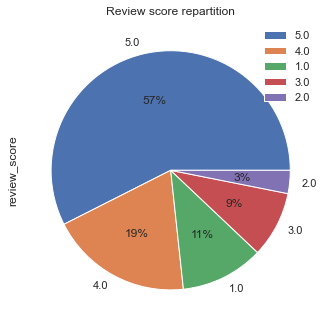

1.0    10708
2.0     2978
3.0     8518
4.0    18340
5.0    54755
Name: review_score, dtype: int64

In [316]:
reviews_counts = reviews_customers.loc[:, 'review_score'].value_counts()
reviews_counts.plot.pie(autopct='%1.0f%%', title = 'Review score repartition').legend()
plt.show()
reviews_counts.sort_index()

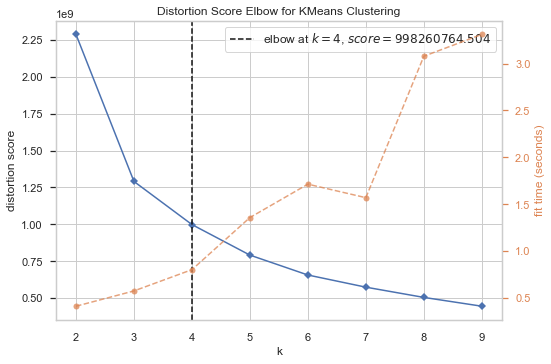

optimal number of cluster is 4


C:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 5\Clustering-Model-Designing\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


223.29s to fit


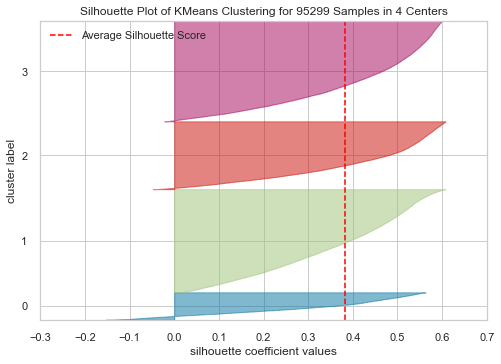

0.02s to fit


C:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 5\Clustering-Model-Designing\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 5\Clustering-Model-Designing\venv\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


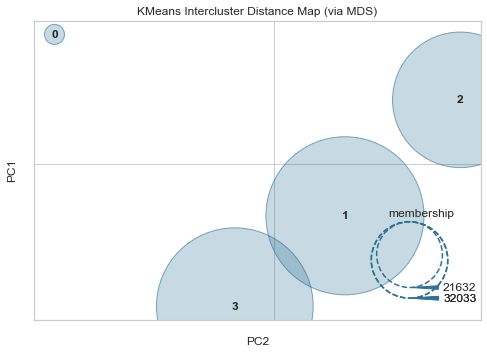

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [317]:
import time
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.icdm import InterclusterDistance
import seaborn as sns

title_fontsize = 25
fig_axis_fontsize = 20
axis_fontsize = 15


data = reviews_customers.loc[:,['Recency', 'Frequency', 'Monetary_value', 'review_score']]

# FINDING THE BEST CLUSTER NUMBER
model = KElbowVisualizer(KMeans(), k=(2,10))
model.fit(data)
model.show()
optimal_cluster_number = model.elbow_value_
print(f"optimal number of cluster is {str(optimal_cluster_number)}")


# REPRESENTATION OF THE 4 VARIABLES
model = KMeans(optimal_cluster_number, random_state=42)
model.fit(data)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted = True)
start_data = time.time()
visualizer.fit(data)
stop_data = time.time()
time_to_fit = stop_data - start_data
print(f'{round(time_to_fit,2)}s to fit')
visualizer.show()

# SHOW CLUSTER REPARTITION ON PCA 2
visualizer = InterclusterDistance(model, is_fitted = True, legend_loc = 'lower right')
start_data = time.time()
visualizer.fit(data)
stop_data = time.time()
time_to_fit = stop_data - start_data
print(f'{round(time_to_fit,2)}s to fit')
visualizer.show()

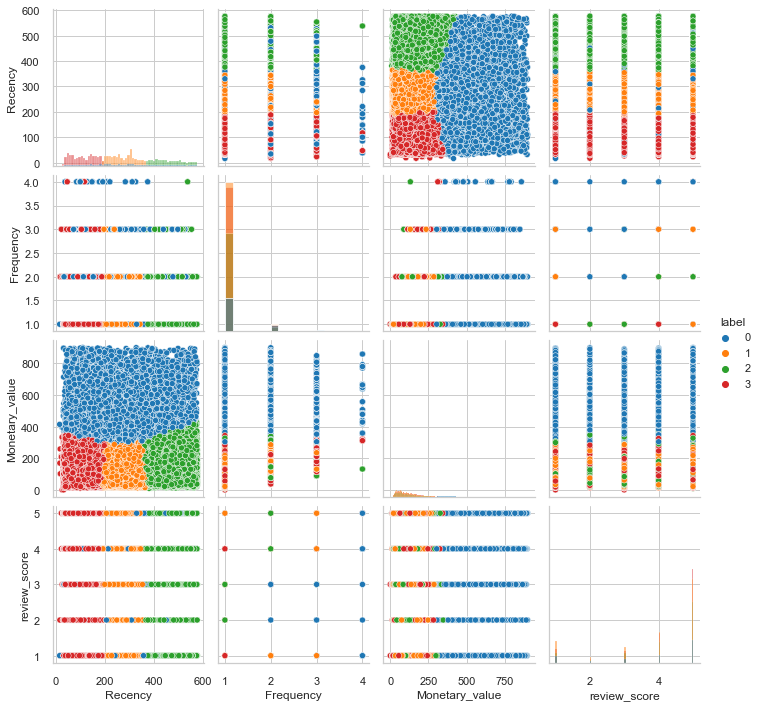

In [318]:
pair_data = data
pair_data['label'] = model.labels_
# sns.pairplot(
#     data = pair_data,
#     hue = 'label',
#     vars = ['Recency', 'Frequency', 'Monetary_value', 'review_score'],
#     diag_kind = 'hist',
#     palette = 'tab10',
# )

## Calculating the training frequency

To have coherent clusters : see [here](https://stats.stackexchange.com/questions/224759/how-to-avoid-k-means-assigning-different-labels-on-different-run)

Now, we will try to estimate the changing cluster speed. We will divide our data into equal subsets based on time. We will set multiple milestone seperated by equal duration and cluster our subsets for every period. Then, by comparing our clusterings, we could evaluate the evolution rate and define a threeshold when we recommend to do another clustering.

1. Define the milestones (serial and later floating)
2. Divide the datasets
3. Clustering
4. Evaluating the clustering
5. Calculate the mean score for these milestones step
6. Repeat

In [343]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta

# Recall from the outliers section
min_datetime = pd.to_datetime('2017-03-01')
max_datetime = pd.to_datetime('2018-09-30')

num_months = (max_datetime.year - min_datetime.year) * 12 + (max_datetime.month - min_datetime.month)
step_in_months = 4
month_list = range(0, num_months + 1, step_in_months)

milestone_list = []

for index, month_to_add in enumerate(month_list):
    start_date = min_datetime + relativedelta(months=month_to_add)
    end_date = start_date + relativedelta(months=step_in_months)
    milestone_list.append({'start_date' :  start_date, 'end_date' : end_date})
    print(f'{index + 1}ème milestone from {start_date.date()} to {end_date.date()}')

1ème milestone from 2017-03-01 to 2017-07-01
2ème milestone from 2017-07-01 to 2017-11-01
3ème milestone from 2017-11-01 to 2018-03-01
4ème milestone from 2018-03-01 to 2018-07-01
5ème milestone from 2018-07-01 to 2018-11-01


In [344]:
train_freq_data = reduced_custom_customers_df.merge(data_orders.loc[:, ['customer_id','order_purchase_timestamp']], how = 'left', on = 'customer_id')
train_freq_data = train_freq_data.drop('customer_id', axis = 1)
train_freq_data.loc[:,'Recency'] = (max_datetime - pd.to_datetime(train_freq_data.loc[:,'order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')).dt.days
for index, milestone in enumerate(milestone_list):
    start_date = milestone['start_date']
    end_date = milestone['end_date']
    condition = (train_freq_data['order_purchase_timestamp'] > start_date) & (train_freq_data['order_purchase_timestamp'] < end_date)
    in_time_orders = train_freq_data[condition]
    milestone_list[index]['orders'] = in_time_orders
    print(f"{index + 1}ème milestone --> {in_time_orders.shape[0]} orders")

1ème milestone --> 11799 orders
2ème milestone --> 16922 orders
3ème milestone --> 26831 orders
4ème milestone --> 26688 orders
5ème milestone --> 12539 orders


In [345]:
model = KMeans(4)

for index, milestone in enumerate(milestone_list):
    orders_milestone_df = milestone['orders'].loc[:, ['Recency', 'Frequency', 'Monetary_value']]
    model.fit(orders_milestone_df)
    milestone_list[index]['labels'] = model.labels_
    print(f"{index + 1}ème milestone : labels saved")
    milestone_list[index]['model'] = model
    print(f"{index + 1}ème milestone : model saved")

1ème milestone : labels saved
1ème milestone : model saved
2ème milestone : labels saved
2ème milestone : model saved
3ème milestone : labels saved
3ème milestone : model saved
4ème milestone : labels saved
4ème milestone : model saved
5ème milestone : labels saved
5ème milestone : model saved


In [346]:
from sklearn.metrics import adjusted_rand_score

# For each model, we will check the score for the n+1 model to predict the n labels
for index, milestone in enumerate(milestone_list):
    # Check if not the last milestone (cannot compare it to the next clustering)
    if index != len(milestone_list)-1 :
        current_labels = milestone['labels']
        next_model = milestone_list[index +1]['model']
        current_orders_prediction_labels = next_model.predict(milestone['orders'].loc[:, ['Recency', 'Frequency', 'Monetary_value']])
        score = adjusted_rand_score(current_labels, current_orders_prediction_labels)
        milestone_list[index]['score'] = score
        print(f"{index + 1}ème milestone performance : {score}")

1ème milestone performance : 0.7802311726274597
2ème milestone performance : 0.8249716607622973
3ème milestone performance : 0.8795386981186694
4ème milestone performance : 0.8787069983744686


In [347]:
score_sum = 0
for index, milestone in enumerate(milestone_list):
    if index != len(milestone_list)-1 :
        score_sum += milestone['score']
        print(f'{index + 1}ème milestone : added score')
mean_score = score_sum/(len(milestone_list)-1)
print(f'mean_score for 2 months step is {mean_score}')

1ème milestone : added score
2ème milestone : added score
3ème milestone : added score
4ème milestone : added score
mean_score for 2 months step is 0.8408621324707237


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


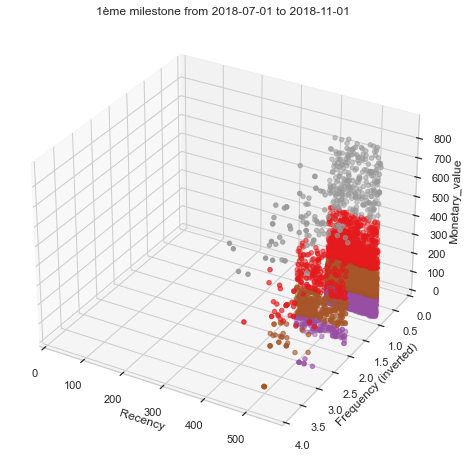

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


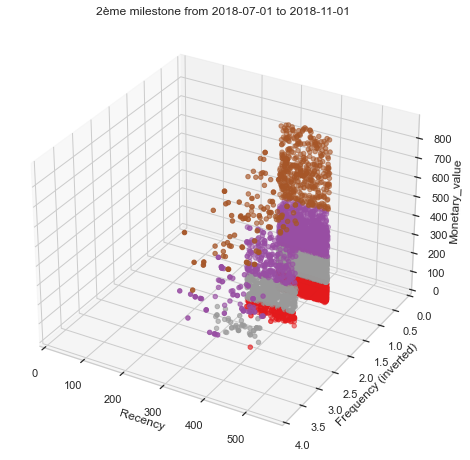

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


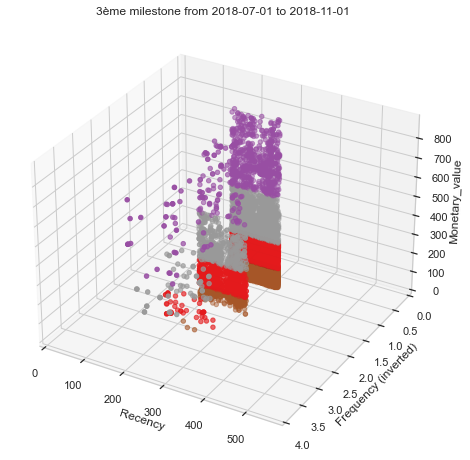

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


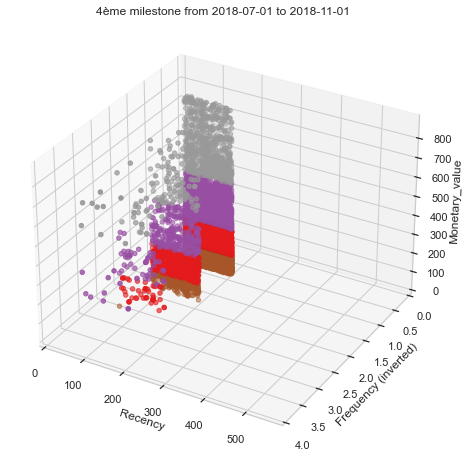

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


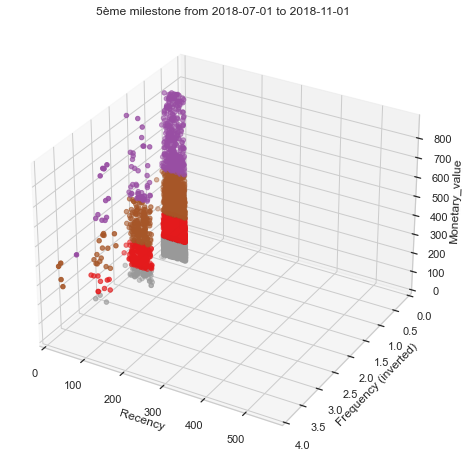

In [348]:


for index, milestone in enumerate(milestone_list):
    orders = milestone['orders']
    dataX = orders.loc[:, 'Recency']
    dataY = orders.loc[:, 'Frequency']
    dataZ = orders.loc[:, 'Monetary_value']
    labels = milestone['labels']
    labelX = 'Recency'
    labelY = 'Frequency (inverted)'
    labelZ = 'Monetary_value'
    title=f'{index + 1}ème milestone from {start_date.date()} to {end_date.date()}'
    revertedX = False
    revertedZ = False
    revertedY = True
    fig = plt.figure(1, figsize=(12,6))

    ax = Axes3D(fig, rect=[0, 0, 1, 1], auto_add_to_figure=False)
    ax.scatter(dataX, dataY, dataZ, c=labels, cmap='Set1')
    fig.add_axes(ax)


    ax.set_title(title)

    ax.set_xlabel(labelX)
    ax.set_xlim(0, max_rec)

    ax.set_ylabel(labelY)
    ax.set_ylim(max_freq, 0)

    ax.set_zlabel(labelZ)
    ax.set_zlim(0, max_mon)

    ax.legend()
    plt.show()

step n° 1 : 1
----1ème milestone from 2017-03-01 to 2017-07-01
----2ème milestone from 2017-04-01 to 2017-08-01
----3ème milestone from 2017-05-01 to 2017-09-01
----4ème milestone from 2017-06-01 to 2017-10-01
----5ème milestone from 2017-07-01 to 2017-11-01
----6ème milestone from 2017-08-01 to 2017-12-01
----7ème milestone from 2017-09-01 to 2018-01-01
----8ème milestone from 2017-10-01 to 2018-02-01
----9ème milestone from 2017-11-01 to 2018-03-01
----10ème milestone from 2017-12-01 to 2018-04-01
----11ème milestone from 2018-01-01 to 2018-05-01
----12ème milestone from 2018-02-01 to 2018-06-01
----13ème milestone from 2018-03-01 to 2018-07-01
----14ème milestone from 2018-04-01 to 2018-08-01
----15ème milestone from 2018-05-01 to 2018-09-01
----16ème milestone from 2018-06-01 to 2018-10-01
----17ème milestone from 2018-07-01 to 2018-11-01
----18ème milestone from 2018-08-01 to 2018-12-01
----19ème milestone from 2018-09-01 to 2019-01-01
----1ème milestone --> 11799 orders
----2ème 

----1ème milestone --> 11799 orders
----2ème milestone --> 27269 orders
----1ème milestone : labels saved
----1ème milestone : model saved
----2ème milestone : labels saved
----2ème milestone : model saved
----1ème milestone performance : 0.9486885017920701
----1ème milestone : added score
mean_score for 11 months step is 0.9486885017920701


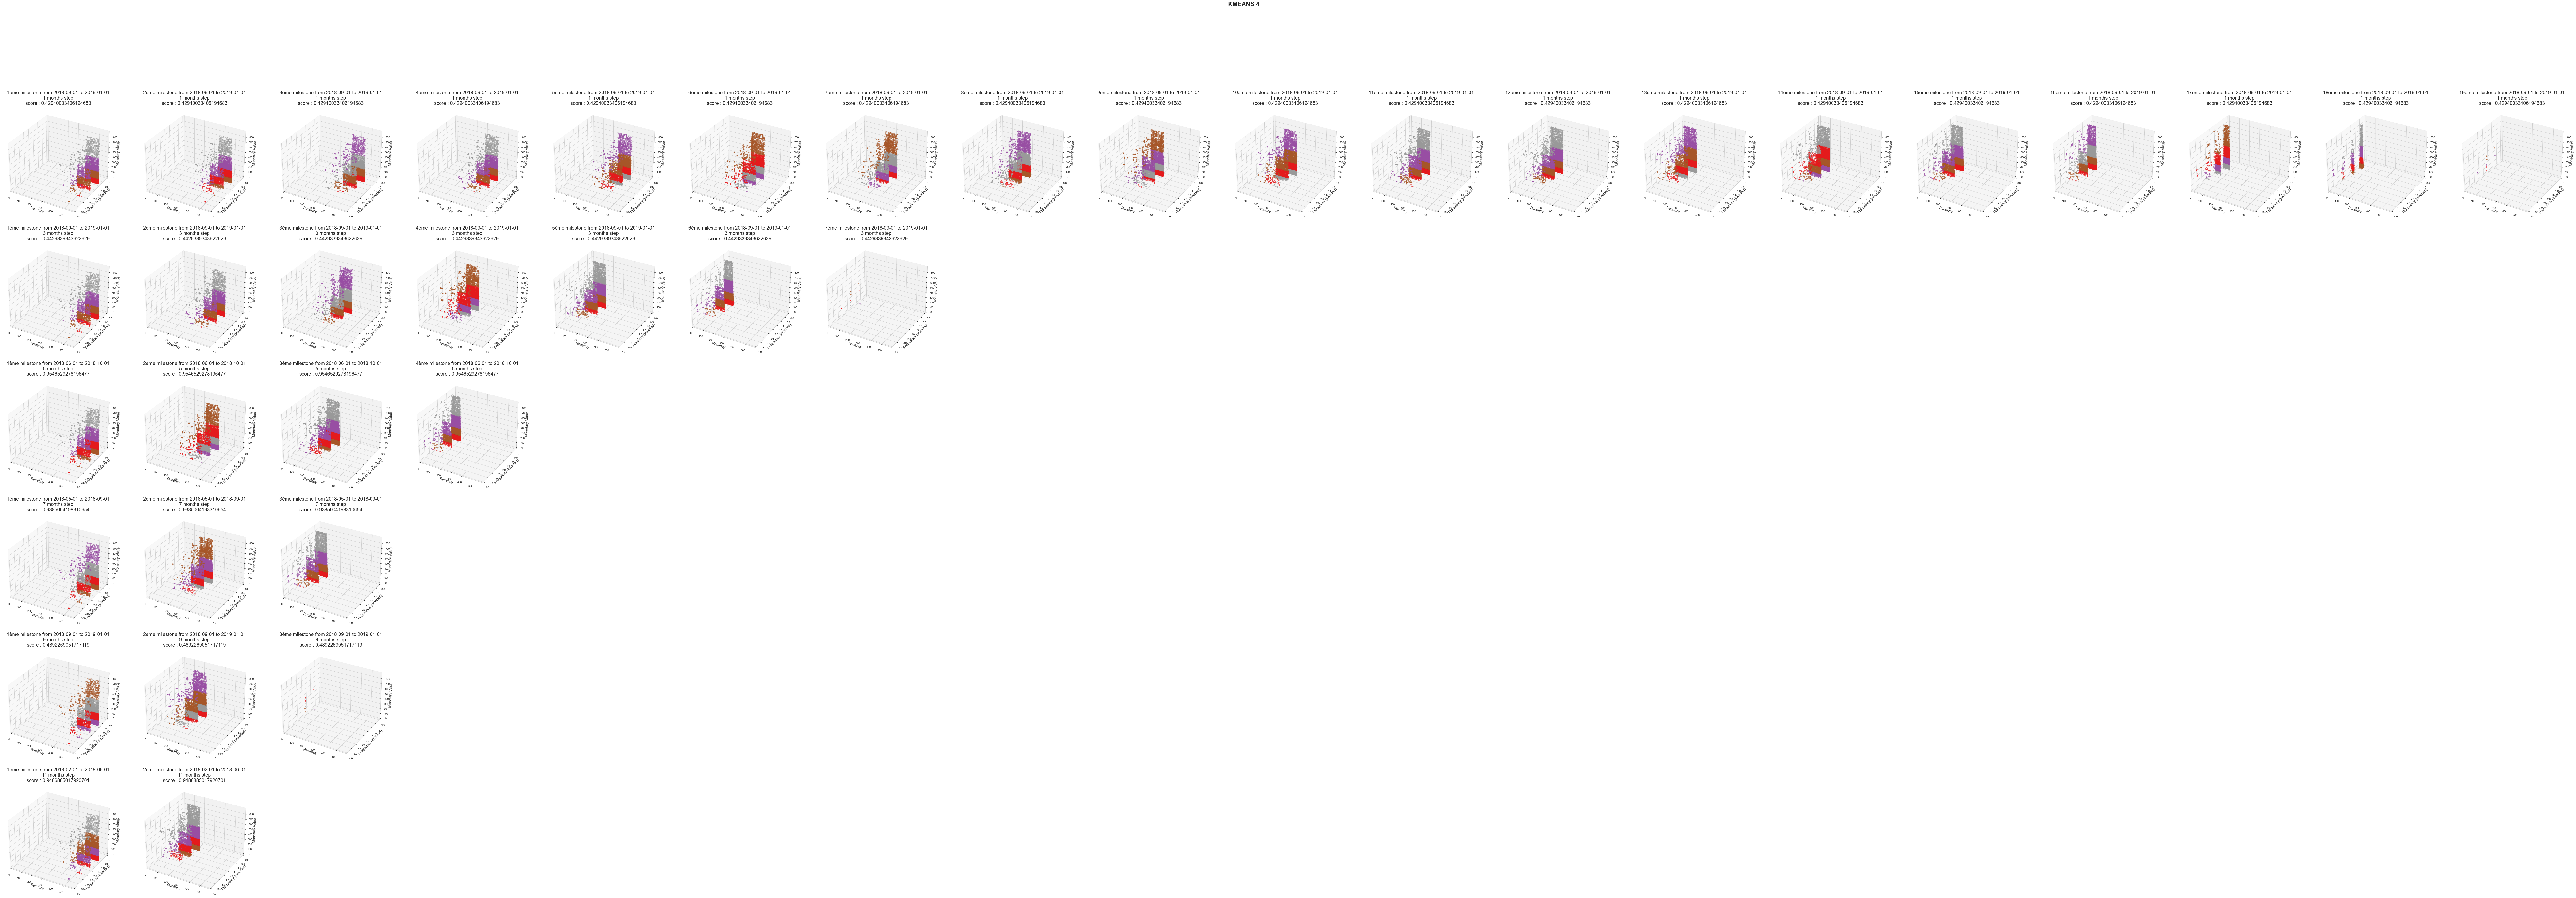

In [413]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.metrics import adjusted_rand_score


model = KMeans(4)

# Recall from the outliers section
min_datetime = pd.to_datetime('2017-03-01')
max_datetime = pd.to_datetime('2018-09-30')

max_freq = train_freq_data.loc[:,'Frequency'].max()
max_rec = train_freq_data.loc[:,'Recency'].max()
max_mon = train_freq_data.loc[:,'Monetary_value'].max()

def scoring_milestones(
    list_steps,
    verbose = False
):
    step_min = list_steps[0]
    
    num_months = (max_datetime.year - min_datetime.year) * 12 + (max_datetime.month - min_datetime.month)
    month_list = range(0, num_months + 1, step_min)
    nb_cols = len(month_list)
    nb_rows = len(list_steps)
    
    fig = plt.figure(figsize=(10 * nb_cols, 10 * nb_rows))
    fig.suptitle('KMEANS 4', fontsize=title_fontsize, fontweight='bold')
    
    # ITERATE OVER STEPS
    for index_step, step in enumerate(list_steps):
        if verbose :
            print(f'step n° {index_step+1} : {step}')
        
        num_months = (max_datetime.year - min_datetime.year) * 12 + (max_datetime.month - min_datetime.month)
        month_list = range(0, num_months + 1, step)

        milestone_list = []
        
        # CONSTRUCT MILESTONES
        for index, month_to_add in enumerate(month_list):
            start_date = min_datetime + relativedelta(months=month_to_add)
            end_date = start_date + relativedelta(months=step_in_months)
            milestone_list.append({'start_date' :  start_date, 'end_date' : end_date})
            if verbose :
                print(f'----{index + 1}ème milestone from {start_date.date()} to {end_date.date()}')
        
        
        # DIVIDE ORDERS FROM MILESTONES
        train_freq_data = reduced_custom_customers_df.merge(data_orders.loc[:, ['customer_id','order_purchase_timestamp']], how = 'left', on = 'customer_id')
        train_freq_data = train_freq_data.drop('customer_id', axis = 1)
        train_freq_data.loc[:,'Recency'] = (max_datetime - pd.to_datetime(train_freq_data.loc[:,'order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')).dt.days
        for index, milestone in enumerate(milestone_list):
            start_date = milestone['start_date']
            end_date = milestone['end_date']
            condition = (train_freq_data['order_purchase_timestamp'] > start_date) & (train_freq_data['order_purchase_timestamp'] < end_date)
            in_time_orders = train_freq_data[condition]
            milestone_list[index]['orders'] = in_time_orders
            if verbose :
                print(f"----{index + 1}ème milestone --> {in_time_orders.shape[0]} orders")
        
        
        # CLUSTER SUBSETS
        for index, milestone in enumerate(milestone_list):
            orders_milestone_df = milestone['orders'].loc[:, ['Recency', 'Frequency', 'Monetary_value']]
            model.fit(orders_milestone_df)
            milestone_list[index]['labels'] = model.labels_
            if verbose :
                print(f"----{index + 1}ème milestone : labels saved")
            milestone_list[index]['model'] = model
            if verbose :
                print(f"----{index + 1}ème milestone : model saved")
            
            
        # PREDICT N+1
        # For each model, we will check the score for the n+1 model to predict the n labels
        for index, milestone in enumerate(milestone_list):
            # Check if not the last milestone (cannot compare it to the next clustering)
            if index != len(milestone_list)-1 :
                current_labels = milestone['labels']
                next_model = milestone_list[index +1]['model']
                current_orders_prediction_labels = next_model.predict(milestone['orders'].loc[:, ['Recency', 'Frequency', 'Monetary_value']])
                score = adjusted_rand_score(current_labels, current_orders_prediction_labels)
                milestone_list[index]['score'] = score
                if verbose :
                    print(f"----{index + 1}ème milestone performance : {score}")
        
        
        # SCORE PREDICTION
        score_sum = 0
        for index, milestone in enumerate(milestone_list):
            if index != len(milestone_list)-1 :
                score_sum += milestone['score']
                if verbose :
                    print(f'----{index + 1}ème milestone : added score')
        mean_score = score_sum/(len(milestone_list)-1)
        if verbose :
            print(f'mean_score for {step} months step is {mean_score}')
        
        

        # PLOT CLUSTERING (NOT PREDICTION)
        for index, milestone in enumerate(milestone_list):
            index_plot = index_step * nb_cols + index + 1
            ax = fig.add_subplot(nb_rows, nb_cols, index_plot, projection = '3d')
            orders = milestone['orders']
            ax.scatter3D(
                            orders.loc[:, 'Recency'],
                            orders.loc[:, 'Frequency'],
                            orders.loc[:, 'Monetary_value'],
                            c=milestone['labels'],
                            cmap='Set1',
                        )

            ax.set_xlabel('Recency', fontsize=axis_fontsize)
            ax.set_xlim(0, max_rec)

            ax.set_ylabel('Frequency (inverted)', fontsize=axis_fontsize)
            ax.set_ylim(max_freq, 0)

            ax.set_zlabel('Monetary Value', fontsize=axis_fontsize)
            ax.set_zlim(0, max_mon)

            ax.set_title(f'{index + 1}ème milestone from {start_date.date()} to {end_date.date()}\n{step} months step\nscore : {mean_score}', fontsize=fig_axis_fontsize)
        
plt.show()


scoring_milestones(range(1,12,2), verbose = True)